In [2]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc
from sklearn.neighbors import KernelDensity

/Users/runburg/github/agn_lf


In [3]:
# catalog = table.Table.read('./data/master_cat_irac3_mips24')
# outfile = 'lf_ir_montecarlo_with_incompleteness'
# specz = 'zspec' 
# photoz = 'z1_median'

catalog = table.Table.read('./data/ir_and_xray.fits')
outfile = 'lf_ir_crossmatch_ir_selected'
specz = 'zspec_1'
# specz = 'redshift'
# photoz = 'ZPHOT'
photoz = 'z1_median'

ra_up = 36.5
ra_down = 34.75
dec_up = -4
dec_down = -5.5
catalog = catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]

flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy[specz], nan=-99) > 0)]
print(len(ct_lacy))

cosmo = af.setup_cosmology()

# 5914
# 1108

821


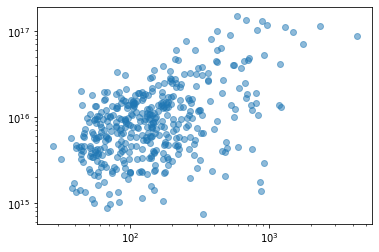

In [10]:
sources = ct_lacy[photoz] < 1.5
ratio = ct_lacy[sources][flux58]/ct_lacy[sources]['FB_FLUX']
plt.scatter(ct_lacy[sources][flux58], ratio, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [4]:
# ct_lacy.colnames

['help_id_1',
 'field',
 'ra_1',
 'dec_1',
 'hp_idx',
 'ebv',
 'redshift',
 'zspec_1',
 'f_irac_i1',
 'ferr_irac_i1',
 'f_ap_irac_i1',
 'ferr_ap_irac_i1',
 'm_irac_i1',
 'merr_irac_i1',
 'm_ap_irac_i1',
 'merr_ap_irac_i1',
 'flag_irac_i1',
 'f_irac_i2',
 'ferr_irac_i2',
 'f_ap_irac_i2',
 'ferr_ap_irac_i2',
 'm_irac_i2',
 'merr_irac_i2',
 'm_ap_irac_i2',
 'merr_ap_irac_i2',
 'flag_irac_i2',
 'f_irac_i3',
 'ferr_irac_i3',
 'f_ap_irac_i3',
 'ferr_ap_irac_i3',
 'm_irac_i3',
 'merr_irac_i3',
 'm_ap_irac_i3',
 'merr_ap_irac_i3',
 'flag_irac_i3',
 'f_irac_i4',
 'ferr_irac_i4',
 'f_ap_irac_i4',
 'ferr_ap_irac_i4',
 'm_irac_i4',
 'merr_irac_i4',
 'm_ap_irac_i4',
 'merr_ap_irac_i4',
 'flag_irac_i4',
 'cigale_mstar',
 'cigale_mstar_err',
 'cigale_sfr',
 'cigale_sfr_err',
 'cigale_dustlumin',
 'cigale_dustlumin_err',
 'cigale_dustlumin_ironly',
 'cigale_dustlumin_ironly_err',
 'flag_cigale',
 'flag_cigale_opt',
 'flag_cigale_ir',
 'flag_cigale_ironly',
 'stellarity',
 'stellarity_origin',
 'flag_c

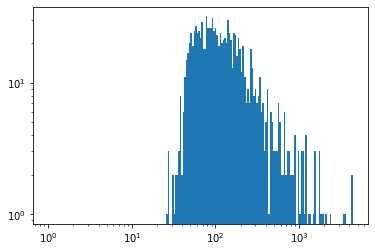

In [4]:
fluxes = np.nan_to_num(catalog[flux58])
plt.hist(catalog[flux58], bins=np.logspace(0, np.log10(fluxes.max()), num=200))
plt.xscale('log')
plt.yscale('log')

In [5]:
# sample parameters
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42
l_sample_max = 3e46

# bins
num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

# coverage
# field_coverage_area = 9.1
field_coverage_area = (ra_up - ra_down) * (dec_up - dec_down)

# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)

# Uncertainties and corrections
full_fluxes = catalog[never_nan][flux58]
goodzs = (ct_lacy[photoz] > 0) & (ct_lacy[specz] > 0)
difs = ct_lacy[photoz][goodzs] - ct_lacy[specz][goodzs]

kds = []
for i in np.arange(len(z_bins)-1):
    inbin = (ct_lacy[photoz][goodzs] > z_bins[i]) & (ct_lacy[photoz][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(ct_lacy[specz][goodzs][inbin][:, None])
    
    kds.append(kde)

bolo_corr = 1
# bolo_corr = 8
# ct_lacy['random_z'] = 0#ct_lacy[photoz]

with np.load('./data/incompleteness_corrections_mag.npz') as f:
    mags = f['mags']
    corrs = f['corrs']
    f_corr = f['fluxes']

corr_fn = intp(f_corr, corrs, bounds_error=False, fill_value=1) 
# MCMC runs
N = 1000


/usr/local/lib/python3.8/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [6]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]

for i in range(N):
    if i % 50 == 0:
        print('progress', round(i/N * 100, 2), '%')
    
    randomz = np.zeros(len(ct_lacy))
#     ### use zphot - zspec to estimate uncertainty on z
#     for j in np.arange(len(z_bins) - 1):
#         inbin = (ct_lacy[photoz][goodzs] >= z_bins[j]) & (ct_lacy[photoz][goodzs] < z_bins[j+1])
# #         histo, bin_edges = np.histogram(difs[inbin], bins=200)
#         histo, bin_edges = np.histogram(difs[inbin], bins=200)

#         photoz_inbin = (ct_lacy[photoz] >= z_bins[j]) & (ct_lacy[photoz] < z_bins[j+1])
#         randomz[photoz_inbin] = ct_lacy[photoz][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
#         while np.any(randomz < 0):
#             indices = randomz < 0
#             randomz[indices] = ct_lacy[photoz][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))
# #         ct_lacy['random_z'][photoz_inbin] = ct_lacy[photoz][photoz_inbin]
    for j, kd in enumerate(kds):
        photoz_inbin = (ct_lacy[photoz] >= z_bins[j]) & (ct_lacy[photoz] < z_bins[j+1])
        randomz[photoz_inbin] = kd.sample(np.sum(photoz_inbin)).flatten()
    
    ct_lacy['random_z'] = randomz
    z = np.array([row[specz] if row[specz] > 0 else row['random_z'] for row in ct_lacy])   
    ###
    
#     z = np.array([row[specz] if row[specz] > 0 else np.random.normal(row[photoz], (row['z1_max'] - row['z1_min'])/2) for row in ct_lacy])   
#     z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])
#     z[z < 0] = 0
    
    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr
    
    good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(time.time() - start_time)
    
    coverage_correction = vmax.coverage_correction(ct_lacy[flux58], ct_lacy[flux58][good_redshift_and_l_selected])
    
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
        
        return field_coverage_area * coverage_correction(flux) * corr_fn(flux)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)
#     print(time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(total_time := time.time() - start_time, total_time/N)


progress 0.0 %
progress 5.0 %
progress 10.0 %
progress 15.0 %
progress 20.0 %
progress 25.0 %
progress 30.0 %
progress 35.0 %
progress 40.0 %
progress 45.0 %
progress 50.0 %
progress 55.0 %
progress 60.0 %
progress 65.0 %
progress 70.0 %
progress 75.0 %
progress 80.0 %
progress 85.0 %
progress 90.0 %
progress 95.0 %
226.14497804641724 0.22614497804641723


In [7]:
np.sum(ct_lacy['random_z'][good_redshift_and_l_selected] > 0), np.sum(ct_lacy[photoz][good_redshift_and_l_selected] > 0)

(631, 680)

(2.4480897150688028e-54, 2.3518464036044483e-07, 0)

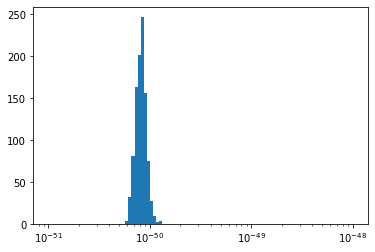

In [8]:
lf_mean = np.mean(lf_chain, axis=0)
lf_mean_err = np.std(lf_chain, axis=0)
# print(lf_mean_err*np.log(10)*(l_bins[1:]-l_bins[:-1])/2)
plt.hist(lf_chain[:, 3, 8], bins=np.logspace(-51, -48, num=100))
ax = plt.gca()
ax.set_xscale('log')
bin_centers = (l_bins[1:]+l_bins[:-1])/2
min(lf_chain[:, 8, -1]), lf_mean[8, -1]*bin_centers[-1]*np.log(10), np.sum(np.isnan(lf_chain))


In [9]:
sorted_lf = np.sort(lf_chain, axis=0)
# probs = np.cumsum(sorted_lf, axis=0)
# probs /= probs[-1]
# probs = np.nan_to_num(probs)
# print(probs)
mid_id = len(sorted_lf) // 2
high_id = (len(sorted_lf) * 84) // 100
low_id = (len(sorted_lf) * 16) // 100
print(low_id, mid_id, high_id, len(sorted_lf))

sh = sorted_lf.shape
median_vals = np.zeros((sh[1], sh[2]))
med_errs = np.zeros((sh[1], 2, sh[2]))
# low_errs = np.zeros((sh[1], sh[2]))
for i in range(sh[1]):
    for j in range(sh[2]):
        median_vals[i, j] = sorted_lf[:, i, j][mid_id]
        med_errs[i, 1, j] = sorted_lf[:, i, j][high_id]
        med_errs[i, 0, j] = sorted_lf[:, i, j][low_id]
        

160 500 840 1000


In [10]:
# plot_files = ['./output/lf_ir_montecarlo.npz']
plot_files = ['./output/lf_ir_montecarlo_with_incompleteness.npz']
labs = ['full HELP catalog']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


In [11]:
hz_convert = 5.8e-6 / 3e8
lit_data = {}
other_limits = {}
lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 47.0, num=50)
lacy_limits = [[44, 46], [44, 46], [44.5, 46.5], [44.5, 46.5], [45, 46.5], [46, 46.5], [46, 46.5], [46.5, 46.5], [46.5, 46.5]]
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
other_limits['Lacy 2015'] = 10**np.array(lacy_limits)
# lacy_mid[1][:10]

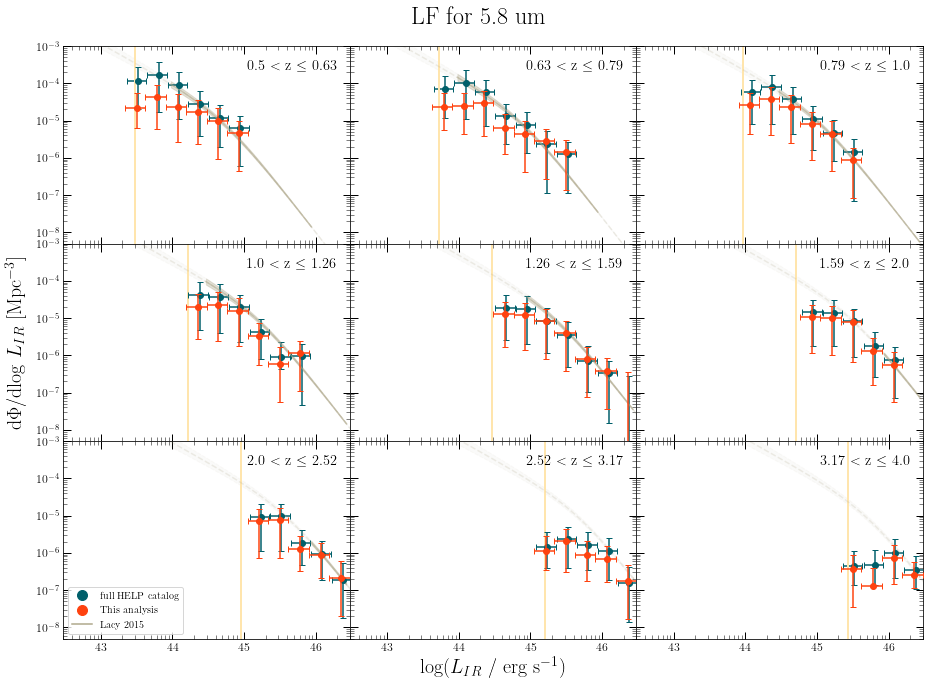

In [12]:
import importlib
importlib.reload(vmax)

# np.savez('./output/lf_ir_crossmatch_xrayselected_montecarlo.npz', lf_vals=median_vals, lf_errs=med_errs)
np.savez('./output/' + outfile + '.npz', lf_vals=median_vals, lf_errs=med_errs)


l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(median_vals, med_errs, z_bins, l_bins, lum_limits=l_limits, \
                                     compare_to_others=lit_data, other_runs=otherruns, title=r'LF for 5.8 $\mathrm{\mu m}$', \
                                     others_limits=other_limits, outfile='./output/' + outfile + '.pdf', lum_sublabel=r'_{IR}')

In [13]:
# cut points below limit

In [14]:
median_vals

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.97855775e-49,
        3.00057994e-49, 8.78071353e-50, 3.16247511e-50, 9.40815100e-51,
        2.41779808e-51, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.66674311e-49, 9.28456300e-50, 5.57528097e-50, 6.26314920e-51,
        2.17372921e-51, 7.44834746e-52, 1.92892635e-52, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.05092357e-50, 9.43454050e-50, 7.33860208e-50, 2.25181674e-50,
        4.04568397e-51, 1.16470867e-51, 1.19727261e-52, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.03930423e-51, 2.61808961e-50, 3.90971468e-50, 2.28953114e-50,
        8.13158798e-51, 9.01111946e-52, 7.87915920e-53, 8.07860847e-53,
        0.000

In [15]:
flux_limit

2.224137931034483e-14

In [16]:
l_limits.shape

(9,)

In [17]:
len(ct_lacy[(ct_lacy[photoz] >= z_bins[-3]) & (ct_lacy[photoz] < z_bins[-2])])

57